# Notebook 01a – Nearest Neighbour Gap Check: LSOA-to-LSOA vs Master GPKG

This notebook inspects coverage gaps between the `LSOA_to_LSOA.csv` (used for nearest neighbour travel or gravity modelling) and the master population geometry file `LSOA_5-year_segment_master.gpkg`. The primary objective is to:

- Identify any **LSOAs missing** from the `LSOA_to_LSOA.csv` network file.
- Confirm **unique LSOA codes** present in both source and target columns.
- Flag any **non-reciprocal entries** or **incomplete edge coverage**.
- Quantify the **population or demand loss** if any LSOAs are entirely disconnected.

### Gap-Filling Approach

To address any missing LSOAs, we propose using a **mean travel time to nearest 3 neighbours** as a proxy, where:
- Missing LSOAs will be linked to **3 nearest available LSOAs** based on geographic centroid distance (from the master GPKG).
- Estimated average travel time will be **imputed conservatively** (e.g., using median of available neighbours).
- This method ensures coverage for all areas in downstream accessibility and demand modelling.


In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import numpy as np
from shapely.geometry import LineString

# --- Paths ---
root = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw")
csv_path = root / "LSOA_to_LSOA.csv"
gpkg_path = root / "LSOA_5-year_segment_master.gpkg"


In [3]:
# --- Paths ---
root = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw")
csv_path = root / "LSOA_to_LSOA.csv"
gpkg_path = root / "LSOA_5-year_segment_master.gpkg"

# --- Load with correct headers ---
df_links = pd.read_csv(csv_path, header=None)
df_links.columns = [
    "origin_lsoa", "destination_lsoa", "travel_time_car",
    "travel_time_car_delay", "travel_time_public"
]

gdf_master = gpd.read_file(gpkg_path)

In [4]:
# --- Preview content ---
print("Link file sample:")
display(df_links.head())

print("Master file sample:")
display(gdf_master.head())

# --- Extract unique LSOAs from both files ---
link_lsoas = pd.unique(df_links[['origin_lsoa', 'destination_lsoa']].values.ravel())
master_lsoas = gdf_master['lsoa21cd'].unique()

# --- Compare lengths and intersection ---
print(f"\nLink file LSOAs: {len(link_lsoas)} unique codes")
print(f"Master GPKG LSOAs: {len(master_lsoas)} unique codes")

# --- Identify missing LSOAs ---
missing_lsoas = sorted(set(master_lsoas) - set(link_lsoas))
print(f"Missing in link file: {len(missing_lsoas)} LSOAs")

# Optional: preview missing
missing_lsoas[:10]


Link file sample:


,origin_lsoa,destination_lsoa,travel_time_car,travel_time_car_delay,travel_time_public
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922
2,E01014654,E01015202,123.315531,146.985531,148.025531
3,E01015028,E01029066,133.568645,255.878645,268.518645
4,E01015316,E01029066,112.233260,227.623260,221.623260


Master file sample:


,ICB23NM,ladnm,ladcd,msoa21nm,msoa21cd,lsoa21nmw,lsoa21cd,total_population,age_0_4,age_5_9,...,age_70_74,age_75_79,age_80_84,age_85_plus,lat,long,bng_e,bng_n,lsoa21nm,geometry
0,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020484,1444.99,43.76,70.21,...,113.97,80.39,63.09,51.90,50.60036,-1.96951,402254,77850,Dorset 042G,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020481,1347.30,39.69,32.56,...,161.80,105.83,61.06,83.44,50.60304,-1.95604,403207,78149,Dorset 042D,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."
2,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020482,1585.42,70.21,77.34,...,132.29,94.64,49.86,52.92,50.60719,-1.96286,402724,78610,Dorset 042E,"MULTIPOLYGON (((403126.904 78828.641, 403127.4..."
3,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020479,1150.91,33.58,32.56,...,106.85,120.08,94.64,155.69,50.61312,-1.96203,402782,79270,Dorset 042B,"MULTIPOLYGON (((403027.597 79673.678, 403027.8..."
4,NHS Dorset Integrated Care Board,Dorset,E06000059,Dorset 042,E02004268,None,E01020478,1129.54,37.65,44.77,...,94.64,83.44,48.84,55.97,50.61287,-1.97186,402087,79241,Dorset 042A,"MULTIPOLYGON (((402493.1 79584.202, 402511.903..."



Link file LSOAs: 3165 unique codes
Master GPKG LSOAs: 3451 unique codes
Missing in link file: 286 LSOAs


['E01014014',
 'E01014031',
 'E01014032',
 'E01014036',
 'E01014057',
 'E01016301',
 'E01016304',
 'E01022983',
 'E01022993',
 'E01022994']

Filtered 286 missing LSOAs from master GeoDataFrame


,lsoa21cd,ladnm,ICB23NM
16,E01034274,"Bournemouth, Christchurch and Poole",NHS Dorset Integrated Care Board
17,E01034278,"Bournemouth, Christchurch and Poole",NHS Dorset Integrated Care Board
24,E01034281,"Bournemouth, Christchurch and Poole",NHS Dorset Integrated Care Board
32,E01034277,"Bournemouth, Christchurch and Poole",NHS Dorset Integrated Care Board
34,E01034273,"Bournemouth, Christchurch and Poole",NHS Dorset Integrated Care Board


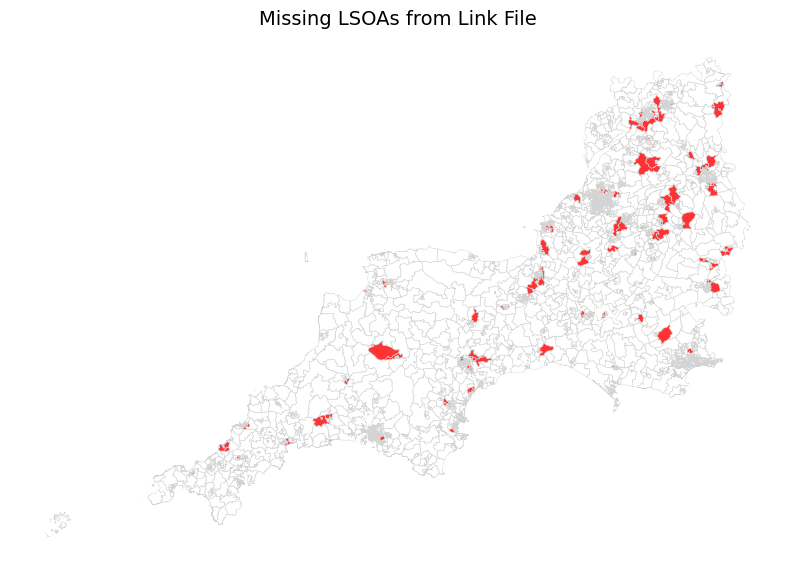

In [5]:
# --- Filter missing LSOAs from the master GeoDataFrame ---
gdf_missing = gdf_master[gdf_master['lsoa21cd'].isin(missing_lsoas)].copy()

# --- Quick check ---
print(f"Filtered {len(gdf_missing)} missing LSOAs from master GeoDataFrame")
display(gdf_missing[['lsoa21cd', 'ladnm', 'ICB23NM']].head())

# --- Plot (static) ---

fig, ax = plt.subplots(figsize=(10, 12))
gdf_master.boundary.plot(ax=ax, linewidth=0.3, color='lightgrey')
gdf_missing.plot(ax=ax, color='red', alpha=0.8)
ax.set_title("Missing LSOAs from Link File", fontsize=14)
plt.axis('off')
plt.show()


In [7]:
# --- Add centroid column to master GeoDataFrame ---
gdf_master['centroid'] = gdf_master.geometry.centroid

# --- Get centroids of missing and valid LSOAs ---
gdf_valid = gdf_master[gdf_master['lsoa21cd'].isin(link_lsoas)].copy()
gdf_missing = gdf_master[gdf_master['lsoa21cd'].isin(missing_lsoas)].copy()

# Extract coordinates
valid_coords = np.array(list(gdf_valid['centroid'].apply(lambda p: (p.x, p.y))))
missing_coords = np.array(list(gdf_missing['centroid'].apply(lambda p: (p.x, p.y))))

# Build KDTree for efficient spatial nearest neighbour search
tree = cKDTree(valid_coords)

# For each missing LSOA, get indices of 3 nearest valid LSOAs
dists, indices = tree.query(missing_coords, k=3)

# --- Build a lookup DataFrame ---
nearest_lookup = []

# Use enumerate to track 0-based index for array access
for i, (_, missing_row) in enumerate(gdf_missing.iterrows()):
    missing_code = missing_row['lsoa21cd']
    for rank, idx in enumerate(indices[i], start=1):
        nearest_row = gdf_valid.iloc[idx]
        nearest_lookup.append({
            'missing_lsoa': missing_code,
            'nearest_lsoa': nearest_row['lsoa21cd'],
            'rank': rank,
            'distance_m': dists[i][rank-1]
        })

df_nearest = pd.DataFrame(nearest_lookup)


In [8]:
print("Nearest neighbours for missing LSOAs:")
display(df_nearest.head(10))

Nearest neighbours for missing LSOAs:


,missing_lsoa,nearest_lsoa,rank,distance_m
0,E01034274,E01033285,1,509.990355
1,E01034274,E01015367,2,616.788260
2,E01034274,E01033242,3,669.302015
3,E01034278,E01015290,1,819.541913
4,E01034278,E01015291,2,886.580939
5,E01034278,E01033285,3,1096.949806
6,E01034281,E01015466,1,458.610445
7,E01034281,E01032661,2,605.624952
8,E01034281,E01032660,3,684.819928
9,E01034277,E01015290,1,823.427653


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_5449/485655141.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


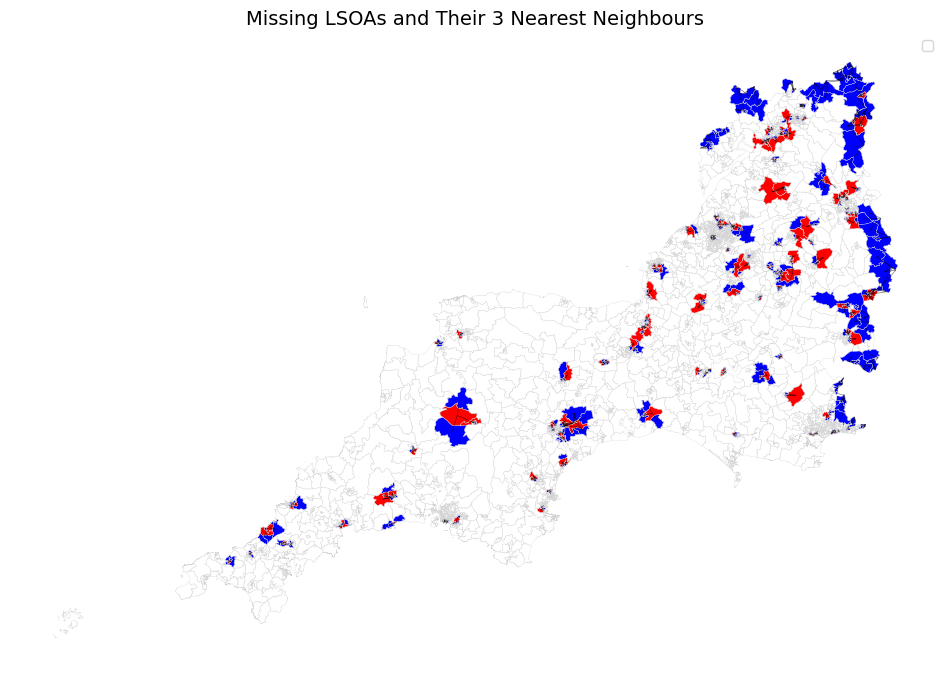

In [9]:


# --- Extract only the nearest LSOAs from the master frame ---
nearest_lsoa_codes = df_nearest['nearest_lsoa'].unique()
gdf_nearest = gdf_master[gdf_master['lsoa21cd'].isin(nearest_lsoa_codes)].copy()

# --- Create LineStrings between each missing and its neighbours ---
lines = []
for _, row in df_nearest.iterrows():
    missing_geom = gdf_missing.loc[gdf_missing['lsoa21cd'] == row['missing_lsoa'], 'centroid'].values[0]
    nearest_geom = gdf_valid.loc[gdf_valid['lsoa21cd'] == row['nearest_lsoa'], 'centroid'].values[0]
    lines.append(LineString([missing_geom, nearest_geom]))

gdf_lines = gpd.GeoDataFrame(geometry=lines, crs=gdf_master.crs)

# --- Plot all together ---
fig, ax = plt.subplots(figsize=(12, 14))
gdf_master.boundary.plot(ax=ax, linewidth=0.2, color='lightgrey')
gdf_nearest.plot(ax=ax, color='blue', markersize=10, label='Nearest Neighbours')
gdf_missing.plot(ax=ax, color='red', markersize=10, label='Missing LSOAs')
gdf_lines.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)

ax.legend()
ax.set_title("Missing LSOAs and Their 3 Nearest Neighbours", fontsize=14)
ax.axis('off')
plt.show()


In [10]:
df_valid_links = df_links[df_links['origin_lsoa'].isin(link_lsoas)].copy()


In [11]:
all_dest_lsoas = pd.DataFrame({'destination_lsoa': master_lsoas})
df_missing_expanded = (
    df_nearest[['missing_lsoa', 'nearest_lsoa']]
    .merge(all_dest_lsoas, how='cross')
)


In [12]:
# Prepare lookup table: (origin → destination) → travel times
df_lookup = df_valid_links.rename(columns={
    'origin_lsoa': 'nearest_lsoa'
})

df_with_times = (
    df_missing_expanded
    .merge(df_lookup, on=['nearest_lsoa', 'destination_lsoa'], how='left')
)


In [13]:
df_imputed = (
    df_with_times
    .groupby(['missing_lsoa', 'destination_lsoa'], as_index=False)
    .agg({
        'travel_time_car': 'mean',
        'travel_time_car_delay': 'mean',
        'travel_time_public': 'mean'
    })
    .rename(columns={'missing_lsoa': 'origin_lsoa'})
)
df_imputed['imputed'] = True


In [14]:
df_imputed = df_imputed[df_imputed['origin_lsoa'] != df_imputed['destination_lsoa']]
df_links['imputed'] = False

df_final = pd.concat([df_links, df_imputed], ignore_index=True)
df_final = df_final.drop_duplicates(subset=['origin_lsoa', 'destination_lsoa'])


In [16]:
# ------------------------
# Densify ALL OD pairs
# ------------------------
import numpy as np
import pandas as pd
import geopandas as gpd

# 0) Inputs from 01a
# gdf_master: master GPKG already loaded with 'lsoa21cd','bng_e','bng_n','geometry'
# df_final: original + nearest-neighbour imputed links (columns: origin_lsoa, destination_lsoa, travel_time_car, ...)

# -- Standardise columns
df_links = df_final.rename(columns={
    "origin_lsoa": "origin_name",
    "destination_lsoa": "destination_name"
}).copy()

# 1) Make the full grid (include diagonal; we’ll set it to 0)
all_ids = sorted(gdf_master["lsoa21cd"].astype(str).str.strip().unique())
grid = pd.MultiIndex.from_product([all_ids, all_ids],
                                  names=["origin_name", "destination_name"]).to_frame(index=False)

# 2) Left-join existing times
od = grid.merge(
    df_links[["origin_name","destination_name","travel_time_car"]],
    on=["origin_name","destination_name"], how="left"
)

# 3) Diagonal = 0 (if missing)
diag_mask = od["origin_name"].eq(od["destination_name"])
od.loc[diag_mask, "travel_time_car"] = od.loc[diag_mask, "travel_time_car"].fillna(0.0)

# 4) Reciprocal fill: use t_ji where t_ij is NaN
rev = od.rename(columns={
    "origin_name":"destination_name",
    "destination_name":"origin_name",
    "travel_time_car":"travel_time_car_rev"
})[["origin_name","destination_name","travel_time_car_rev"]]
od = od.merge(rev, on=["origin_name","destination_name"], how="left")
needs = od["travel_time_car"].isna() & od["origin_name"].ne(od["destination_name"])
od.loc[needs, "travel_time_car"] = od.loc[needs, "travel_time_car_rev"]
od = od.drop(columns=["travel_time_car_rev"])

# 5) Nearest-origin borrowing for EVERY origin (K=3)
#    For missing (o,d), take K nearest origins to o (by centroid),
#    and average their known t(nn,d). This generalises your 01a idea.
coords = gdf_master[["lsoa21cd","bng_e","bng_n"]].dropna()
coords["lsoa21cd"] = coords["lsoa21cd"].astype(str).str.strip()
coords = coords.set_index("lsoa21cd")

# Precompute 3 nearest origins for all o
from scipy.spatial import cKDTree
tree = cKDTree(coords[["bng_e","bng_n"]].to_numpy())
_, idxs = tree.query(coords[["bng_e","bng_n"]].to_numpy(), k=3)
nn_map = {o: [all_ids[i] for i in idxs[j]] for j, o in enumerate(all_ids)}  # rank-preserving

# Build a lookup for fast nn borrowing: t(nn,d)
od_indexed = od.set_index(["origin_name","destination_name"])["travel_time_car"]
t_lookup = od_indexed.unstack(0)  # columns = origin; rows = destination

# Borrow where still missing
missing_mask = od["travel_time_car"].isna() & od["origin_name"].ne(od["destination_name"])
if missing_mask.any():
    sub = od.loc[missing_mask, ["origin_name","destination_name"]].copy()
    # For each row, gather the K nn origins and average their times to d
    def borrow_time(row):
        nn = nn_map.get(row["origin_name"], [])
        vals = t_lookup.loc[row["destination_name"], nn].to_numpy(dtype=float)
        vals = vals[~np.isnan(vals)]
        return np.mean(vals) if len(vals) else np.nan
    borrowed = sub.apply(borrow_time, axis=1)
    od.loc[missing_mask, "travel_time_car"] = borrowed.values

# 6) Euclidean fallback for any remaining gaps (very few by now)
still = od["travel_time_car"].isna() & od["origin_name"].ne(od["destination_name"])
if still.any():
    o_xy = coords.loc[od.loc[still,"origin_name"]][["bng_e","bng_n"]].to_numpy()
    d_xy = coords.loc[od.loc[still,"destination_name"]][["bng_e","bng_n"]].to_numpy()
    d_m = np.hypot(o_xy[:,0] - d_xy[:,0], o_xy[:,1] - d_xy[:,1])
    # Assume 50 km/h → minutes
    od.loc[still, "travel_time_car"] = (d_m/1000.0) / (50.0/60.0)

# Optional cap so decay beyond 60 min → ~0 anyway
od["travel_time_car"] = od["travel_time_car"].clip(upper=600)

# 7) Final tidy + checks
assert od["travel_time_car"].isna().sum() == 0, "NaNs remain in car times"
expected = len(all_ids) * len(all_ids)
assert len(od) == expected, f"Row count mismatch: {len(od)} vs {expected}"

# Save the truly complete matrix
out_path = (root / "LSOA_to_LSOA_complete_densified.csv")  # adjust 'root' to your path var
od.to_csv(out_path, index=False)
print(f"✅ Wrote dense OD: {out_path}  | rows={len(od):,}")


✅ Wrote dense OD: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_to_LSOA_complete_densified.csv  | rows=11,909,401


In [17]:
# Check how many unique LSOAs now appear as origins
origin_coverage = set(df_final['origin_lsoa'])
destination_coverage = set(df_final['destination_lsoa'])
all_lsoas = set(master_lsoas)

print(f"Origin coverage: {len(origin_coverage & all_lsoas)} / 3451")
print(f"Destination coverage: {len(destination_coverage & all_lsoas)} / 3451")


Origin coverage: 3451 / 3451
Destination coverage: 3451 / 3451


In [18]:
# Define final output path
output_path = root / "LSOA_to_LSOA_complete.csv"

# Rename columns
df_export = df_final.rename(columns={
    'origin_lsoa': 'origin_name',
    'destination_lsoa': 'destination_name',
    'travel_time_car': 'travel_time_car',
    'travel_time_public': 'travel_time_pt_peak',
    'travel_time_car_delay': 'travel_time_pt_nonpeak'
})

# Optional: drop imputed column if not needed
df_export = df_export[['origin_name', 'destination_name',
                       'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']]

# Export to CSV
df_export.to_csv(output_path, index=False)

# Confirm output
print(f"Exported with {df_export.shape[0]:,} rows to:")
print(output_path)

# Preview result
display(df_export.head())


Exported with 11,003,925 rows to:
/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_to_LSOA_complete.csv


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak
0,E01022150,E01014950,42.748168,56.288168,56.288168
1,E01029238,E01033364,85.033922,126.483922,126.483922
2,E01014654,E01015202,123.315531,148.025531,146.985531
3,E01015028,E01029066,133.568645,268.518645,255.878645
4,E01015316,E01029066,112.233260,221.623260,227.623260
